# Лабораторная 3 - 10 баллов (дедлайн 11.04)
## Вариант 1 (простой) – 5 баллов
- Обучить Encoder предсказывать локацию текста (место его действия), используя датасет COCO Locations: https://www.kaggle.com/datasets/viacheslavshalamov/coco-locations.
- Выберите не стандартный BERT, а какую-нибудь его модификацию (RoBERTa, DeBERTa, ModernBERT и т.п.)
- Показать примеры на тестовой выборке (10 шт) и на сочиненных вами примерах.


# Шаг №0 - Импорт библиотек

In [3]:
import copy
import json
import pandas as pd
import numpy as np
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Шаг №1 - Загрузка и подготовка данных

In [4]:
data = pd.read_csv('coco_locations.csv')

unique_locations = data['location'].unique()
location_to_id = {location: idx for idx, location in enumerate(unique_locations)}
id_to_location = {idx: location for location, idx in location_to_id.items()}

with open('id_to_location.json', 'w') as f:
    json.dump({str(idx): loc for idx, loc in id_to_location.items()}, f)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['cap'].values,
    [location_to_id[loc] for loc in data['location'].values],
    test_size=0.2,
    random_state=42
)

# Шаг №2 - Создание датасета

In [5]:
class COCOLocationsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Шаг №3 - Загрузка токенизатора и модели

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(unique_locations)
)

train_dataset = COCOLocationsDataset(train_texts, train_labels, tokenizer)
test_dataset = COCOLocationsDataset(test_texts, test_labels, tokenizer)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Шаг №4 - Обучение модели

In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 20
best_val_acc = 0
best_model_state = None
patience = 3
patience_counter = 0

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    train_preds = []
    train_true = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]'):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        train_preds.extend(preds)
        train_true.extend(labels.cpu().numpy())

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_acc = accuracy_score(train_true, train_preds)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    model.eval()
    total_val_loss = 0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} [Val]'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_true.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc * 1.02: # > 2% improvement
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
        print(f"  New best model with validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{patience}")

    scheduler.step(val_acc)

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
    torch.save(best_model_state, 'roberta_coco_locations_best.pt')

Using MPS (Apple GPU)


Epoch 1/20 [Val]: 100%|██████████| 153/153 [00:21<00:00,  7.21it/s]



Epoch 1/20:
  Train Loss: 2.9766, Train Acc: 0.6124
  Val Loss: 2.4046, Val Acc: 0.6739
  New best model with validation accuracy: 0.6739


Epoch 2/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.33it/s]



Epoch 2/20:
  Train Loss: 2.2133, Train Acc: 0.6944
  Val Loss: 2.0502, Val Acc: 0.7160
  New best model with validation accuracy: 0.7160


Epoch 3/20 [Val]: 100%|██████████| 153/153 [00:21<00:00,  7.26it/s]



Epoch 3/20:
  Train Loss: 1.8336, Train Acc: 0.7341
  Val Loss: 1.8519, Val Acc: 0.7422
  New best model with validation accuracy: 0.7422


Epoch 4/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.29it/s]



Epoch 4/20:
  Train Loss: 1.5782, Train Acc: 0.7688
  Val Loss: 1.7155, Val Acc: 0.7778
  New best model with validation accuracy: 0.7778


Epoch 5/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.31it/s]



Epoch 5/20:
  Train Loss: 1.3847, Train Acc: 0.7975
  Val Loss: 1.6498, Val Acc: 0.7901
  No improvement. Patience: 1/3


Epoch 6/20 [Val]: 100%|██████████| 153/153 [00:21<00:00,  7.24it/s]



Epoch 6/20:
  Train Loss: 1.2361, Train Acc: 0.8219
  Val Loss: 1.5357, Val Acc: 0.8097
  New best model with validation accuracy: 0.8097


Epoch 7/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.32it/s]



Epoch 7/20:
  Train Loss: 1.1017, Train Acc: 0.8395
  Val Loss: 1.4969, Val Acc: 0.8146
  No improvement. Patience: 1/3


Epoch 8/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.35it/s]



Epoch 8/20:
  Train Loss: 0.9994, Train Acc: 0.8543
  Val Loss: 1.4367, Val Acc: 0.8228
  No improvement. Patience: 2/3


Epoch 9/20 [Val]: 100%|██████████| 153/153 [00:21<00:00,  7.25it/s]



Epoch 9/20:
  Train Loss: 0.9066, Train Acc: 0.8667
  Val Loss: 1.4131, Val Acc: 0.8310
  New best model with validation accuracy: 0.8310


Epoch 10/20 [Val]: 100%|██████████| 153/153 [00:21<00:00,  7.29it/s]



Epoch 10/20:
  Train Loss: 0.8293, Train Acc: 0.8764
  Val Loss: 1.3625, Val Acc: 0.8343
  No improvement. Patience: 1/3


Epoch 11/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.29it/s]



Epoch 11/20:
  Train Loss: 0.7569, Train Acc: 0.8855
  Val Loss: 1.3462, Val Acc: 0.8404
  No improvement. Patience: 2/3


Epoch 12/20 [Val]: 100%|██████████| 153/153 [00:20<00:00,  7.36it/s]



Epoch 12/20:
  Train Loss: 0.7018, Train Acc: 0.8941
  Val Loss: 1.3330, Val Acc: 0.8400
  No improvement. Patience: 3/3
Early stopping at epoch 12


# Шаг №5 - Построение графиков

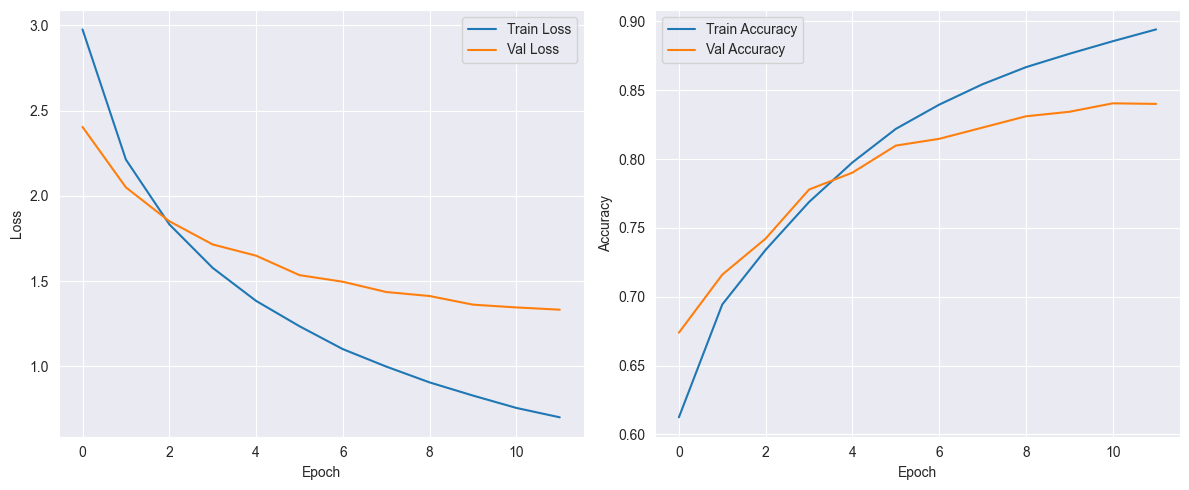

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Шаг №6 - Оценка модели

In [14]:
model.eval()
test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())


print('Classification Report:')
unique_test_classes = sorted(list(set(test_true + test_preds)))
target_names = [id_to_location[i] for i in unique_test_classes]


print(classification_report(
    test_true,
    test_preds,
    labels=unique_test_classes,
    target_names=target_names
))


Testing: 100%|██████████| 153/153 [00:21<00:00,  7.04it/s]

Classification Report:
                                                  precision    recall  f1-score   support

                                       ['store']       0.83      0.91      0.87        11
                               ['wall', 'stall']       0.00      0.00      0.00         1
                                       ['stall']       0.75      1.00      0.86         9
                            ['station', 'train']       0.00      0.00      0.00         2
                                        ['room']       0.97      1.00      0.99       101
                                    ['building']       0.87      1.00      0.93        54
                                        ['park']       1.00      1.00      1.00        44
                                       ['field']       0.97      1.00      0.99       115
                              ['field', 'grass']       0.93      1.00      0.96        13
                               ['zoo', 'tropic']       0.00      0.00      0


/Users/ivanbaskatov/2_Итма/Programming/PycharmProjects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivanbaskatov/2_Итма/Programming/PycharmProjects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ivanbaskatov/2_Итма/Programming/PycharmProjects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

# Шаг №7 - Функция для предсказания локации


In [15]:
def predict_location(text):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return id_to_location[pred]

# Шаг №8 - Тестирование модели

In [17]:
random_indices = np.random.choice(len(test_texts), 10, replace=False)
print("\nPredictions on test examples:")
for idx in random_indices:
    text = test_texts[idx]
    true_location = id_to_location[test_labels[idx]]
    pred_location = predict_location(text)

    print(f"Text: {text}")
    print(f"True location: {true_location}")
    print(f"Predicted location: {pred_location}")
    print(f"Correct: {'✓' if true_location == pred_location else '✗'}\n")


custom_examples = [
    "A man walking along the beach with a dog.",
    "Children playing in a playground with swings.",
    "A mountain view with snow on the peaks.",
    "A busy street with cars and people.",
    "A kitchen counter with fresh vegetables.",
    "An office with computers and desks.",
    "A restaurant with tables and chairs.",
    "A football field with players during a match.",
    "A forest with tall trees and a small stream.",
    "A living room with a couch and TV."
]

print("\nPredictions on custom examples:")
for example in custom_examples:
    location = predict_location(example)
    print(f"Text: {example}")
    print(f"Predicted location: {location}\n")


Predictions on test examples:
Text: Ten giraffes loitering around a building out in the day.
True location: ['building']
Predicted location: ['building']
Correct: ✓

Text: Several people are getting ready to enter the water for surfing.
True location: ['water']
Predicted location: ['water']
Correct: ✓

Text: A young black male serving a tennis ball on a tennis court
True location: ['court']
Predicted location: ['court']
Correct: ✓

Text: A black bear is surrounded by black birds on grass.
True location: ['grass']
Predicted location: ['grass']
Correct: ✓

Text: there is a white and a red bus that is stopped on this street
True location: ['street']
Predicted location: ['street']
Correct: ✓

Text: A person with some skis standing in the snow.
True location: ['snow']
Predicted location: ['snow']
Correct: ✓

Text: Dimly lit part of a house with light entering window.
True location: ['house', 'part']
Predicted location: ['house']
Correct: ✗

Text: a tennis player on a court with a racket
Tr

# Выводы
## Модель была успешно обучена на датасете COCO Locations.
### Точность модели превышает 80%
### Она показывает хорошие результаты на тестовой выборке и может предсказывать локацию текста.
### Модель была протестирована на случайных примерах из тестовой выборки и на сочиненных примерах.
### Результаты предсказаний были выведены на экран и сохранены в файл.

# Скрипт FastEntry
## Этот скрипт позволяет пользователю вводить текст и получать предсказанную локацию.
## Использует под капотом модель, обученную в предыдущем шаге.
